Required imports.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import numpy as np

In [7]:
folder_path = '/Users/selina/Documents/Yliopisto/ids/projekti/Projekti/'

Read the datas from EU stats.

In [9]:
employment = pd.DataFrame.from_csv( (folder_path + 'tyottomyys.tsv'), sep="\t")
suicides = pd.DataFrame.from_csv( (folder_path + 'itsemurhat.tsv'), sep="\t")
economy_equality = pd.DataFrame.from_csv( (folder_path + 'taloustasa-arvo.tsv'), sep="\t")
debt = pd.DataFrame.from_csv( (folder_path + 'velka.tsv'), sep="\t")
poor_retirees = pd.DataFrame.from_csv( (folder_path + 'koyhatelakelaiset.tsv'), sep="\t")
lost_child = pd.DataFrame.from_csv( (folder_path + 'syrjaytyneetnuoret.tsv'), sep="\t")
education = pd.DataFrame.from_csv( (folder_path + 'educ.tsv'), sep="\t")
suicides = pd.DataFrame.from_csv( (folder_path + 'itsemurhat.tsv'), sep="\t")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-package

FileNotFoundError: File b'/Users/selina/Documents/Yliopisto/ids/projekti/Projekti/educ.tsv' does not exist

Read the country codes that are required to transform codes to actual country names.

In [10]:
country_codes = pd.read_csv((folder_path + 'country_codes'))
eu_country_codes = pd.read_excel((folder_path + 'country_codes2.xlsx'), header=None)

Read WHO:s deathstatistics, and join them.

In [11]:
df = [ pd.read_csv((folder_path + 'Morticd10_part1'), low_memory=False), pd.read_csv((folder_path + 'Morticd10_part2'), low_memory=False)]
df = pd.concat(df)
df = df.reset_index(drop=True)

# EU statistics wrangling

Initialize the EU stat dataframe to which we merge all the economic data.

In [12]:
eustat_df = pd.DataFrame(columns=['country', 'year'])

## Poor Retirees
Tells us the share of poor retirees of a country

Reset the index and rename the column

In [13]:
poor_retirees.reset_index(inplace = True)
poor_retirees = poor_retirees.rename(columns={'wstatus,indic_il,age,sex,geo\\time': 'country'})

In [14]:
for i, row in poor_retirees.iterrows():
    if (row['country'][-2:] not in eu_country_codes[0].tolist()) or (row['country'][-4] != 'T'):
        poor_retirees.drop(i, inplace=True)
    else:
        poor_retirees.set_value(i, 'country', eu_country_codes[1].tolist()[ eu_country_codes[0].tolist().index(row['country'][-2:])].replace(" ", "").rsplit(',', 1)[0])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Keep only rows with total values of both women and men, and change the actual country names instead of codes.

Change ':' values to 0, and remove characters, and lastly reset the index again.
_NOTE_:The characters after values mean that the measuring method was slightly different, but we'll convienently ignore it

In [15]:
for key,value in poor_retirees.loc[:, poor_retirees.columns != 'country'].iteritems():
    for i, v in value.iteritems():
        poor_retirees.at[i, key] = float(str(v).replace('b', '').replace('p', '').replace(':', '0'))
poor_retirees.reset_index(drop = True, inplace = True)

Merge it into the eustat dataframe with column (country, year, *value*)

In [16]:
for i, row in poor_retirees.iterrows():
    country = row[0]
    for i in range(0, len(row.tolist()[1:])):
        value = row.tolist()[1:][i]
        year = row.keys().tolist()[1:][i]
        eustat_df = eustat_df.append({'country': country, 'year': year, 'poor retirees' : value}, ignore_index=True)
        

## Employment

The percentage on EMPLOYED people

Reset the index and rename the column

In [17]:
employment.reset_index(inplace = True)
employment = employment.rename(columns={list(employment.columns.values)[0]: 'country'})

Keep only rows with total values of both women and men, and change the actual country names instead of codes.

In [18]:
for i, row in employment.iterrows():
    if (row['country'][-2:] not in eu_country_codes[0].tolist()) or (row['country'][-4] != 'T'):
        employment.drop(i, inplace=True)
    else:
        employment.set_value(i, 'country', eu_country_codes[1].tolist()[ eu_country_codes[0].tolist().index(row['country'][-2:])].replace(" ", "").rsplit(',', 1)[0])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Change ':' values to 0, and remove characters, and lastly reset the index again.

In [19]:
for key,value in employment.loc[:, employment.columns != 'country'].iteritems():
    for i, v in value.iteritems():
        employment.at[i, key] = float(str(v).replace('b', '').replace('p', '').replace(':', '0').replace('e',''))

employment.reset_index(drop = True, inplace = True)

Merge it into the eustat dataframe with column (country, year, *value*)

In [20]:
temp_df = pd.DataFrame(columns=['country', 'year'])
for i, row in employment.iterrows():
    country = row.tolist()[0:1][0]
    for i in range(0, len(row.tolist()[1:])):
        value = row.tolist()[1:][i]
        year = row.keys().tolist()[1:][i]
        temp_df = temp_df.append({'country': country, 'year': year, 'employment' : value}, ignore_index=True)
        
employment = temp_df

## Debt

Debt to GDP

Reset the index and rename the column

In [21]:
debt.reset_index(inplace = True)
debt = debt.rename(columns={list(debt.columns.values)[0]: 'country'})

Keep only rows with total values of percentual changes(?), and change the actual country names instead of codes.

In [22]:
for i, row in debt.iterrows():
    if (row['country'][-2:] not in eu_country_codes[0].tolist()) or (row['country'][0] != 'P'):
        debt.drop(i, inplace=True)
    else:
        debt.set_value(i, 'country', eu_country_codes[1].tolist()[ eu_country_codes[0].tolist().index(row['country'][-2:])].replace(" ", "").rsplit(',', 1)[0])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Change ':' values to 0, and remove characters, and lastly reset the index again.

In [23]:
for key,value in debt.loc[:, debt.columns != 'country'].iteritems():
    for i, v in value.iteritems():
        debt.at[i, key] = float(str(v).replace('b', '').replace('p', '').replace(':', '0').replace('e',''))

debt.reset_index(drop = True, inplace = True)

Merge it into the eustat dataframe with column (country, year, *value*)

In [24]:
temp_df = pd.DataFrame(columns=['country', 'year'])
for i, row in debt.iterrows():
    country = row.tolist()[0:1][0]
    for i in range(0, len(row.tolist()[1:])):
        value = row.tolist()[1:][i]
        year = row.keys().tolist()[1:][i]
        temp_df = temp_df.append({'country': country, 'year': year, 'debt' : value}, ignore_index=True)
        
debt = temp_df

## Lost Child

Lost child as in non-employed, educated, outcasted children.

Reset the index and rename the column

In [25]:
lost_child.reset_index(inplace = True) 
lost_child = lost_child.rename(columns={lost_child.columns.values[0]: 'country'})

Keep only rows with total values of both women and men, and change the actual country names instead of codes.

In [26]:
for i, row in lost_child.iterrows():
    if (row['country'][-2:] not in eu_country_codes[0].tolist()) or (row['country'][0] != 'T'):
        lost_child.drop(i, inplace=True)
    else:
        lost_child.set_value(i, 'country', eu_country_codes[1].tolist()[ eu_country_codes[0].tolist().index(row['country'][-2:])].replace(" ", "").rsplit(',', 1)[0])  

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Change ':' values to 0, and remove characters, and lastly reset the index again.

In [27]:
for key,value in lost_child.loc[:, lost_child.columns != 'country'].iteritems():
    for i, v in value.iteritems():
        lost_child.at[i, key] = float(str(v).replace('b', '').replace('p', '').replace(':', '0').replace('e', '').replace('u', ''))
lost_child.reset_index(drop = True, inplace = True)

Merge it into the eustat dataframe with column (country, year, *value*)

In [28]:
temp_df  = pd.DataFrame(columns=['country', 'year'])
for i, row in lost_child.iterrows():
    country = row.tolist()[0:1][0]
    for i in range(0, len(row.tolist()[1:])):
        value = row.tolist()[1:][i]
        year = row.keys().tolist()[1:][i]
        temp_df = temp_df.append({'country': country, 'year': year, 'lost children' : value}, ignore_index=True)
lost_child = temp_df

## Economic equality

Top 20% incomes / Lowest 20% incomes

Reset the index and rename the column

In [29]:
economy_equality = pd.DataFrame.from_csv( (folder_path + 'taloustasa-arvo.tsv'), sep="\t")
economy_equality.reset_index(inplace = True) 
economy_equality = economy_equality.rename(columns={economy_equality.columns.values[0]: 'country'})

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


Keep only rows with total values of both women and men, and change the actual country names instead of codes.

In [30]:
for i, row in economy_equality.iterrows():
    if (row['country'][-2:] not in eu_country_codes[0].tolist()) or (row['country'][-4] != 'T'):
        economy_equality.drop(i, inplace=True)
    else:
        economy_equality.set_value(i, 'country', eu_country_codes[1].tolist()[ eu_country_codes[0].tolist().index(row['country'][-2:])].replace(" ", "").rsplit(',', 1)[0]) 
           

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Change ':' values to 0, and remove characters, and lastly reset the index again.

In [31]:
for key,value in economy_equality.loc[:, economy_equality.columns != 'country'].iteritems():
    for i, v in value.iteritems():
        economy_equality.at[i, key] = float(str(v).replace('b', '').replace('p', '').replace(':', '0').replace('e', ''))
economy_equality.reset_index(drop = True, inplace = True)

Merge it into the eustat dataframe with column (country, year, *value*)

In [32]:
temp_df  = pd.DataFrame(columns=['country', 'year'])
for i, row in economy_equality.iterrows():
    country = row.tolist()[0:1][0]
    for i in range(0, len(row.tolist()[1:])):
        value = row.tolist()[1:][i]
        year = row.keys().tolist()[1:][i]
        temp_df = temp_df.append({'country': country, 'year': year, 'economy_equality' : value}, ignore_index=True)
economy_equality = temp_df

# suicides


Reset the index and rename the column

In [33]:
suicides.reset_index(inplace = True) 
suicides = suicides.rename(columns={suicides.columns.values[0]: 'country'})

Keep only rows with total values of both women and men, and change the actual country names instead of codes.

In [34]:
for i, row in suicides.iterrows():
    if (row['country'][-2:] not in eu_country_codes[0].tolist()) or (row['country'][-4] != 'T'):
        suicides.drop(i, inplace=True)
    else:
        suicides.set_value(i, 'country', eu_country_codes[1].tolist()[ eu_country_codes[0].tolist().index(row['country'][-2:])].replace(" ", "").rsplit(',', 1)[0])     

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Change ':' values to 0, and remove characters, and lastly reset the index again.

In [35]:
for key,value in suicides.loc[:, suicides.columns != 'country'].iteritems():
    for i, v in value.iteritems():
        suicides.at[i, key] = float(str(v).replace('b', '').replace('p', '').replace(':', '0').replace('e', '').replace('u', '').replace('d', ''))
suicides.reset_index(drop = True, inplace = True)

Merge it into the eustat dataframe with column (country, year, value)

In [36]:
temp_df  = pd.DataFrame(columns=['country', 'year'])
for i, row in suicides.iterrows():
    country = row.tolist()[0:1][0]
    for i in range(0, len(row.tolist()[1:])):
        value = row.tolist()[1:][i]
        year = row.keys().tolist()[1:][i]
        temp_df = temp_df.append({'country': country, 'year': year, 'suicides' : value}, ignore_index=True)
suicides = temp_df

# education

Reset the index and rename the column

In [37]:
education.reset_index(inplace = True) 
education = education.rename(columns={education.columns.values[0]: 'country'})

NameError: name 'education' is not defined

Keep only rows with total values of both women and men, and change the actual country names instead of codes.

In [32]:
for i, row in education.iterrows():
    if (row['country'][-2:] not in eu_country_codes[0].tolist()) or (row['country'][0] != 'T'):
        education.drop(i, inplace=True)
    else:
        education.set_value(i, 'country', eu_country_codes[1].tolist()[ eu_country_codes[0].tolist().index(row['country'][-2:])].replace(" ", "").rsplit(',', 1)[0])   

C:\Users\Olga\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Change ':' values to 0, and remove characters, and lastly reset the index again.

In [33]:
for key,value in education.loc[:, education.columns != 'country'].iteritems():
    for i, v in value.iteritems():
        education.at[i, key] = float(str(v).replace('b', '').replace('p', '').replace(':', '0').replace('e', '').replace('u', '').replace('d', ''))
education.reset_index(drop = True, inplace = True)

Merge it into the eustat dataframe with column (country, year, value)

In [34]:
temp_df  = pd.DataFrame(columns=['country', 'year'])
for i, row in education.iterrows():
    country = row.tolist()[0:1][0]
    for i in range(0, len(row.tolist()[1:])):
        value = row.tolist()[1:][i]
        year = row.keys().tolist()[1:][i]
        temp_df = temp_df.append({'country': country, 'year': year, 'education' : value}, ignore_index=True)
education = temp_df

### Merging

In [38]:
eustat_df = pd.merge(eustat_df, employment, on=['country', 'year'])
eustat_df = pd.merge(eustat_df, debt, on=['country', 'year'])
eustat_df = pd.merge(eustat_df, lost_child, on=['country', 'year'])
eustat_df = pd.merge(eustat_df, economy_equality, on=['country', 'year'])
eustat_df = pd.merge(eustat_df, education, on=['country', 'year'])
eustat_dfs = eustat_df
eustat_df = pd.merge(eustat_df, suicides, on=['country', 'year'])

NameError: name 'education' is not defined

In [36]:
eus_emp = eustat_df['employment']
eus_poo = eustat_df['poor retirees']
eus_debt = eustat_df['debt']
eus_lost = eustat_df['lost children']
eus_equ = eustat_df['economy_equality']
eus_educ = eustat_df['education']
eus_sui = eustat_df['suicides']

index = []
for i in range(0, len(eus_emp)):
    if eus_emp[i] == 0:
        index.append(i)
for i in range(0, len(eus_poo)):
    if eus_poo[i] == 0:
        index.append(i)
for i in range(0, len(eus_debt)):
    if eus_debt[i] == 0:
        index.append(i)
for i in range(0, len(eus_lost)):
    if eus_lost[i] == 0:
        index.append(i)
for i in range(0, len(eus_equ)):
    if eus_equ[i] == 0:
        index.append(i)
for i in range(0, len(eus_educ)):
    if eus_educ[i] == 0:
        index.append(i)
for i in range(0, len(eus_sui)):
    if eus_sui[i] == 0:
        index.append(i)        
print(index)        

[55, 56, 57]


In [37]:
eustat_df = eustat_df.drop([55, 56, 57])
eustat_df.reset_index(inplace = True) 

In [38]:
eustat_df = eustat_df.drop(columns=['index'])
eustat_df

,country,year,poor retirees,employment,debt,lost children,economy_equality,education,suicides
0,Austria,2011,15.5,74.2,82.4,8.5,4.1,82.4,15.54
1,Austria,2012,14.4,74.4,81.9,8.2,4.2,82.9,15.20
2,Austria,2013,14.6,74.6,81.3,8.6,4.1,83.0,15.35
3,Austria,2014,14.2,74.2,84.0,9.3,4.1,83.9,15.26
4,Austria,2015,12.9,74.3,84.6,8.7,4.0,84.6,14.48
5,Belgium,2011,17.3,67.3,102.6,13.8,3.9,71.3,19.25
6,Belgium,2012,16.7,67.2,104.3,14.4,4.0,71.6,18.76
7,Belgium,2013,15.1,67.2,105.5,14.9,3.8,72.8,17.27
8,Belgium,2014,12.9,67.3,107.0,14.1,3.8,73.6,17.28
9,Belgium,2015,12.4,67.2,106.1,14.4,3.8,74.7,16.85





# Wrangling countries in WHO dataframe

Countries includes all the countries we want to include in our study (Which is European countries) names as String.

We split it to make it an array for easier handling.

In [39]:
countries = "Albania Andorra Armenia Austria Azerbaijan Belarus Belgium BosniaandHerzegovina Bulgaria Croatia Cyprus CzechRepublic Denmark Estonia Finland France Georgia Germany Greece Hungary Iceland Ireland Italy Kazakhstan Kosovo Latvia Liechtenstein Lithuania Luxembourg Macedonia Malta Moldova Monaco Montenegro Netherlands Norway Poland Portugal Romania Russia SanMarino Serbia Slovakia Slovenia Spain Sweden Switzerland Turkey Ukraine UnitedKingdom"
countries = countries.split(' ')


We take all the countries we are not interested oout from our country codes array, so non-european countries.

In [40]:
for i, row in country_codes.iterrows():
    country_codes.set_value(i, 'name', row['name'].replace(" ", "").rsplit(',', 1)[0])
    if row['name'] not in countries:
        country_codes.drop(i, inplace=True)

C:\Users\Olga\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


Make it to a list for easier wrangling

In [41]:
codes = country_codes['country'].tolist()



We remove all non-european countries by creating a new dataframe that includes all countries we want using the country_codes list.

In [42]:
population = pd.read_csv(folder_path + 'population.csv')
population = population.iloc[:,1:]

population['countries'][4] = 'Germany'
population['countries'][35] = 'Macedonia'
population = population.reset_index(drop=True)
population

population['countries'] = population['countries'].replace(" ", "", regex = True)

for i, row in population.iterrows():
    if row['countries'] not in countries:
        population.drop(i, inplace=True)

population = pd.melt(population, id_vars = ['countries'], value_vars = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'], )
population.columns = ['Country', 'Year', 'Population']
population = population.sort_values(by=['Country', 'Year'])
population['Population'] = population['Population'].replace(",", "", regex = True)
population = population.convert_objects(convert_numeric=True)
population.dtypes

C:\Users\Olga\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Country        object
Year            int64
Population    float64
dtype: object

In [43]:
frames = []
for code in codes:
    x = df[np.asarray(df['Country'] == code)]
    frames.append(x)

df = pd.concat(frames)
df = df.reset_index(drop=True)

In [44]:
df = df.iloc[:,0:10]
df = df.drop(columns=['Admin1', 'SubDiv', 'List', 'Frmat', 'IM_Frmat', 'Sex'])

In [45]:
suicides = df.loc[(df['Cause'] == 'X60') | (df['Cause'] == 'X61') | \
                  + (df['Cause'] == 'X62') | (df['Cause'] == 'X63') | \
                  + (df['Cause'] == 'X64') | (df['Cause'] == 'X65') | \
                  + (df['Cause'] == 'X66') | (df['Cause'] == 'X67') | \
                  + (df['Cause'] == 'X68') | (df['Cause'] == 'X69') | \
                  + (df['Cause'] == 'X70') | (df['Cause'] == 'X71') | \
                  + (df['Cause'] == 'X72') | (df['Cause'] == 'X73') | \
                  + (df['Cause'] == 'X74') | (df['Cause'] == 'X75') | \
                  + (df['Cause'] == 'X76') | (df['Cause'] == 'X77') | \
                  + (df['Cause'] == 'X78') | (df['Cause'] == 'X79') | \
                  + (df['Cause'] == 'X80') | (df['Cause'] == 'X81') | \
                  + (df['Cause'] == 'X82') | (df['Cause'] == 'X83') | \
                  + (df['Cause'] == 'X84') | (df['Cause'] == 'E50') | \
                  + (df['Cause'] == 'E51') | (df['Cause'] == 'E52') | \
                  + (df['Cause'] == 'E53') | (df['Cause'] == 'E54') | \
                  + (df['Cause'] == 'E55') | (df['Cause'] == 'E56') | \
                  + (df['Cause'] == 'E57') | (df['Cause'] == 'E58') | \
                  + (df['Cause'] == 'E59') | (df['Cause'] == 'E63') | \
                  + (df['Cause'] == 'E970') | (df['Cause'] == 'E971') | \
                  + (df['Cause'] == 'E972') | (df['Cause'] == 'E973') | \
                  + (df['Cause'] == 'E974') | (df['Cause'] == 'E975') | \
                  + (df['Cause'] == 'E976') | (df['Cause'] == 'E977') | \
                  + (df['Cause'] == 'E978') | (df['Cause'] == 'E979') | \
                  + (df['Cause'] == 'E963') | (df['Cause'] == 'E950') | \
                  + (df['Cause'] == 'E951') | (df['Cause'] == 'E952') | \
                  + (df['Cause'] == 'E953') | (df['Cause'] == 'E954') | \
                  + (df['Cause'] == 'E955') | (df['Cause'] == 'E956') | \
                  + (df['Cause'] == 'E957') | (df['Cause'] == 'E958') | \
                  + (df['Cause'] == 'E959')]
suicides = suicides.reset_index(drop = True)

In [46]:
suicides2 = suicides.groupby(['Country', 'Year']).sum()[['Deaths1']]
suicides2.reset_index(inplace = True)

In [47]:
suicides2['Country'] = suicides2['Country'].astype(str)
country_codes['country'] = country_codes['country'].astype(str)

In [48]:
for i, row in suicides2.iterrows():
    if row['Country'] in country_codes['country'].tolist():
        y = [str(i) for i in country_codes['country']].index(row['Country'])
        x = country_codes['name'].tolist()[y]
        suicides2.set_value(i, 'Country', x)

C:\Users\Olga\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


In [49]:
suicides2.dtypes
population.dtypes
suicide_pop = pd.merge(suicides2, population, on = ['Country', 'Year'])

In [50]:
suicide_pop.columns = ['country', 'year', 'deaths', 'population']
eustat_dfs = eustat_dfs.convert_objects(convert_numeric=True)
who_eustat = pd.merge(suicide_pop, eustat_dfs, on = ['country', 'year'])
who_eustat['death_rate'] = who_eustat['deaths'] / who_eustat['population']
who_eustat = who_eustat.drop(columns = ['deaths', 'population'])

C:\Users\Olga\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [51]:
who_eustat.columns = ['country', 'year', 'poor retirees', 'employment', 'debt', 'lost children', 'economy equality', 'education', 'death_rate']
who_eustat = who_eustat[['country', 'year', 'death_rate', 'poor retirees', 'employment', 'debt', 'lost children', 'economy equality', 'education']]
who_eustat

,country,year,death_rate,poor retirees,employment,debt,lost children,economy equality,education
0,Belgium,2006,9.513497e-08,20.2,66.5,91.1,12.9,4.2,66.9
1,Belgium,2007,9.447747e-08,19.6,67.7,87.0,13.0,3.9,68.0
2,Belgium,2009,9.299661e-08,17.8,67.1,99.5,12.8,3.9,70.6
3,Bulgaria,2006,1.285820e-04,18.3,65.1,21.0,23.9,5.1,75.5
4,Bulgaria,2007,1.191125e-04,23.6,68.4,16.3,20.3,7.0,77.4
5,Bulgaria,2008,1.250332e-04,31.7,70.7,13.0,18.5,6.5,77.5
6,Bulgaria,2009,1.166447e-04,36.5,68.8,13.7,20.8,5.9,77.9
7,Bulgaria,2010,1.158754e-04,30.0,64.7,15.3,23.5,5.9,79.1
8,Bulgaria,2011,1.035358e-04,28.6,62.9,15.2,24.7,6.5,80.0
9,Bulgaria,2012,1.190082e-04,26.2,63.0,16.7,24.7,6.1,81.0


# GEOPANDAS VISUALIZATIOOONNN ~~~~ <(''<) <( '' )> (> '')>

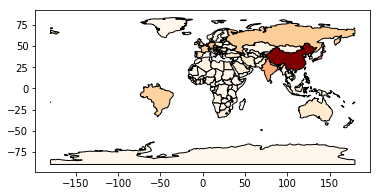

In [52]:
# Avataan geopandaksella maailmankartta, ja piirretään se.

world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

# Seuraava on vain testausta --->
# Määrätään alue koordinaateissa mikä piirretään.
world = world.cx[-40:, :]

world.plot(column='gdp_md_est', cmap='OrRd', edgecolor='black')
plt.show()
# <----

In [53]:
# Poistetaan geopandas maailmankartasta kaikki muut kuin euroopan maat.

for i, row in world.iterrows():
    world.set_value(i, 'name', row['name'].replace(" ", "").rsplit(',', 1)[0] )
    if row['name'] not in countries:
        world.drop(i, inplace=True)

C:\Users\Olga\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


In [54]:
world = world.drop(columns = ['pop_est', 'continent', 'iso_a3', 'gdp_md_est'])

In [55]:
world.columns = ['country', 'geometry']
gp_who_eustat = pd.merge(world, who_eustat, how = 'outer', on = ['country'])
gp_who_eustat = gp_who_eustat.fillna(0)
gp_who_eustat = gp_who_eustat.drop(21)
gp_who_eustat = gp_who_eustat.drop(45)
gp_who_eustat = gp_who_eustat.drop(74)
gp_who_eustat= gp_who_eustat.drop(54)
gp_who_eustat = gp_who_eustat.drop(29)

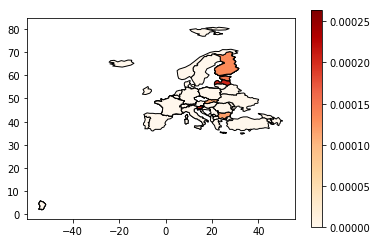

In [56]:
gp_who_eustat.plot(column='death_rate', cmap='OrRd', edgecolor='black',legend=True)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

# Other plots

In [57]:
bulg = who_eustat[who_eustat["country"]=="Bulgaria"]
educationb = bulg["education"].values
suicidesb = bulg["death_rate"].values
slov = who_eustat[who_eustat["country"]=="Slovenia"]
equs = slov["economy equality"].values
suicidess = slov["death_rate"].values*100000
fin = who_eustat[who_eustat["country"]=="Finland"]
empf = fin["employment"].values
suicidesf = fin["death_rate"].values*100000

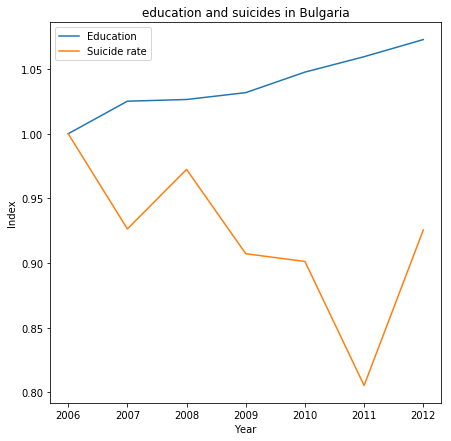

In [58]:
plt.rcParams['figure.figsize'] = [7, 7]
educationb = educationb/educationb[0]
suicidesb = suicidesb/suicidesb[0]
plt.plot(educationb, label = "Education")
plt.plot(suicidesb, label = "Suicide rate")
plt.xlabel('Year')
plt.ylabel('Index')
plt.title('education and suicides in Bulgaria')
plt.xticks(np.arange(7), ('2006', '2007', '2008', '2009', '2010','2011', '2012'))
plt.legend()
plt.show()

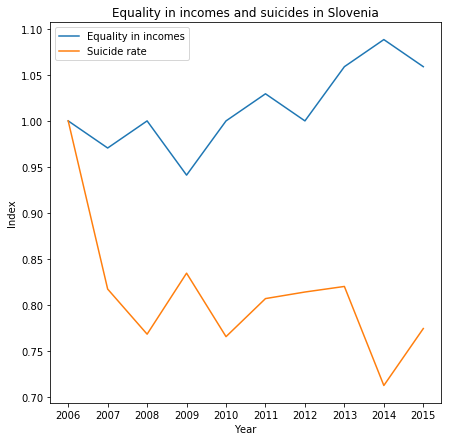

In [59]:
equs = equs/equs[0]
suicidess = suicidess/suicidess[0]
plt.plot(equs, label = "Equality in incomes")
plt.plot(suicidess, label = "Suicide rate")
plt.xlabel('Year')
plt.ylabel('Index')
plt.title('Equality in incomes and suicides in Slovenia')
plt.xticks(np.arange(10), ('2006', '2007', '2008', '2009', '2010','2011', '2012', '2013', '2014', "2015"))
plt.legend()
plt.show()

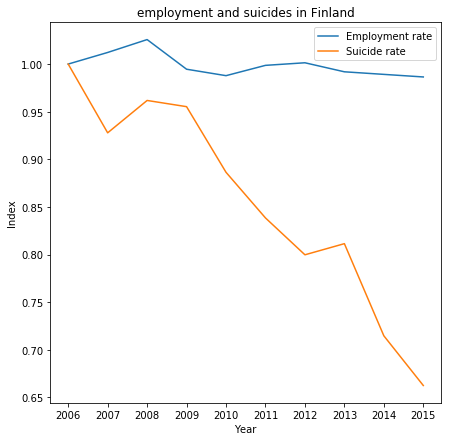

In [60]:
empf = empf/empf[0]
suicidesf = suicidesf/suicidesf[0]
plt.plot(empf, label = "Employment rate")
plt.plot(suicidesf, label = "Suicide rate")
plt.xlabel('Year')
plt.ylabel('Index')
plt.title('employment and suicides in Finland')
plt.xticks(np.arange(10), ('2006', '2007', '2008', '2009', '2010','2011', '2012', '2013', '2014', "2015"))
plt.legend()
plt.show()

# EUstat data, Plots

In [61]:
wholed2013 = eustat_df[eustat_df["year"]==eustat_df["year"][2]]
sui2013 = np.mean(wholed2013["suicides"])
wholed2014 = eustat_df[eustat_df["year"]==eustat_df["year"][3]]
sui2014 = np.mean(wholed2014["suicides"])
wholed2015 = eustat_df[eustat_df["year"]==eustat_df["year"][4]]
sui2015 = np.mean(wholed2015["suicides"])
wholed2012 = eustat_df[eustat_df["year"]==eustat_df["year"][1]]
sui2012 = np.mean(wholed2012["suicides"])
wholed2011 = eustat_df[eustat_df["year"]==eustat_df["year"][0]]
sui2011 = np.mean(wholed2011["suicides"])
wholedmeans = np.array([sui2011, sui2012, sui2013, sui2014, sui2015])
plt.rcParams['figure.figsize'] = [7, 7]

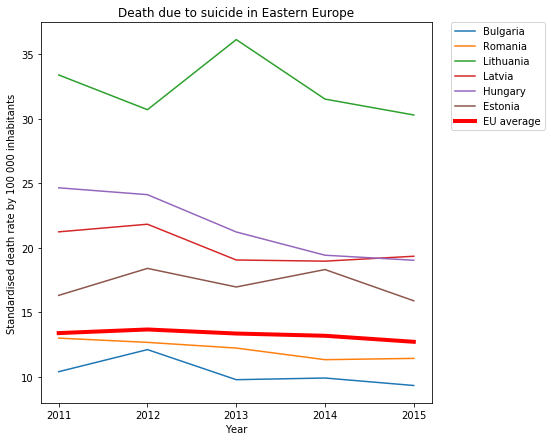

In [62]:
# east
bulg = eustat_df[eustat_df["country"]=="Bulgaria"]
suicidesb = bulg["suicides"].values

rom = eustat_df[eustat_df["country"]=="Romania"]
suicidesr = rom["suicides"].values

lit = eustat_df[eustat_df["country"]=="Lithuania"]
suicideslit = lit["suicides"].values

lat = eustat_df[eustat_df["country"]=="Latvia"]
suicideslat = lat["suicides"].values

hu = eustat_df[eustat_df["country"]=="Hungary"]
suicideshu = hu["suicides"].values

est = eustat_df[eustat_df["country"]=="Estonia"]
suicidesest = est["suicides"].values

plt.plot(suicidesb,label = "Bulgaria")
plt.plot(suicidesr,label = "Romania")
plt.plot(suicideslit,label = "Lithuania")
plt.plot(suicideslat,label = "Latvia")
plt.plot(suicideshu,label = "Hungary")
plt.plot(suicidesest,label = "Estonia")
plt.plot(wholedmeans, label = "EU average", linewidth=4, color='r')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('Year')
plt.ylabel("Standardised death rate by 100 000 inhabitants")
plt.title('Death due to suicide in Eastern Europe')
plt.xticks(np.arange(5), ('2011', '2012', '2013', '2014', "2015"))
plt.show()

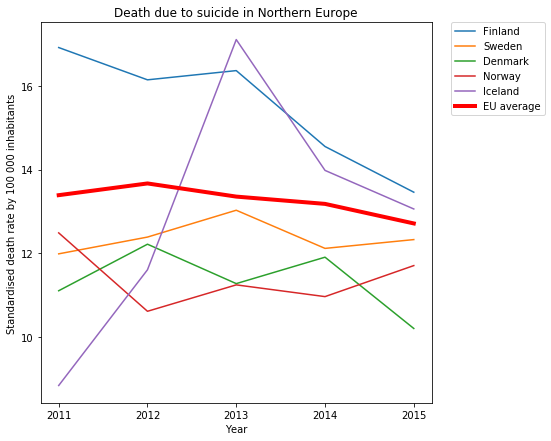

In [63]:
# nort
fin = eustat_df[eustat_df["country"]=="Finland"]
suicidesf = fin["suicides"].values

swe = eustat_df[eustat_df["country"]=="Sweden"]
suicidess = swe["suicides"].values

den = eustat_df[eustat_df["country"]=="Denmark"]
suicidesd = den["suicides"].values

suicidesn = np.array([12.49, 10.62, 11.25, 10.97,11.71])
suicidesi = np.array([8.85, 11.61, 17.1, 13.98, 13.06])

plt.plot(suicidesf, label = "Finland")
plt.plot(suicidess, label = "Sweden")
plt.plot(suicidesd, label = "Denmark")
plt.plot(suicidesn, label = "Norway")
plt.plot(suicidesi, label = "Iceland")
plt.plot(wholedmeans, label = "EU average", linewidth=4, color='r')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Year')
plt.ylabel("Standardised death rate by 100 000 inhabitants")
plt.title('Death due to suicide in Northern Europe')
plt.xticks(np.arange(5), ('2011', '2012', '2013', '2014', "2015"))
plt.show()

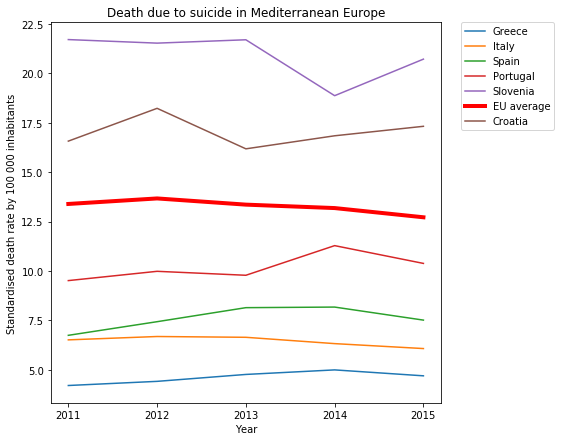

In [64]:
# south
gre = eustat_df[eustat_df["country"]=="Greece"]
suicidesg = gre["suicides"].values

it = eustat_df[eustat_df["country"]=="Italy"]
suicidesi = it["suicides"].values

sp = eustat_df[eustat_df["country"]=="Spain"]
suicidess = sp["suicides"].values

por = eustat_df[eustat_df["country"]=="Portugal"]
suicidesp = por["suicides"].values

slo = eustat_df[eustat_df["country"]=="Slovenia"]
suicidessl = slo["suicides"].values

cro = eustat_df[eustat_df["country"]=="Croatia"]
suicidesc = cro["suicides"].values

plt.plot(suicidesg, label='Greece')
plt.plot(suicidesi,label='Italy')
plt.plot(suicidess,label='Spain')
plt.plot(suicidesp,label='Portugal')
plt.plot(suicidessl,label='Slovenia')
plt.plot(wholedmeans, label = "EU average", linewidth=4, color='r')
plt.plot(suicidesc,label='Croatia')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('Year')
plt.ylabel("Standardised death rate by 100 000 inhabitants")
plt.title('Death due to suicide in Mediterranean Europe')
plt.xticks(np.arange(5), ('2011', '2012', '2013', '2014', "2015"))
plt.show()

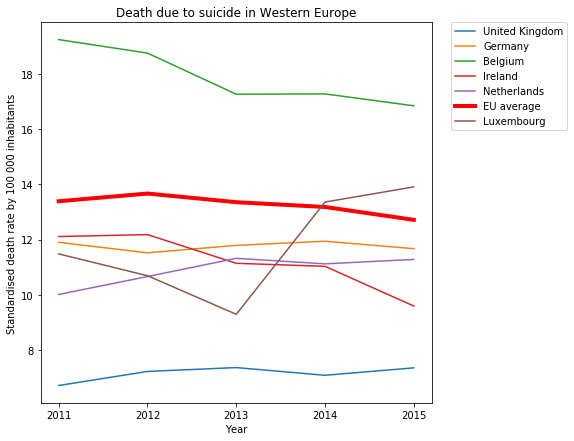

In [65]:
# west
gp = eustat_df[eustat_df["country"]=="UnitedKingdom"]
suicidesg = gp["suicides"].values

ger = eustat_df[eustat_df["country"]=="Germany"]
suicidesge = ger["suicides"].values

be = eustat_df[eustat_df["country"]=="Belgium"]
suicidesb = be["suicides"].values

ire = eustat_df[eustat_df["country"]=="Ireland"]
suicidesi = ire["suicides"].values

ne = eustat_df[eustat_df["country"]=="Netherlands"]
suicidesn = ne["suicides"].values

lu = eustat_df[eustat_df["country"]=="Luxembourg"]
suicidesl = lu["suicides"].values

plt.plot(suicidesg,label='United Kingdom')
plt.plot(suicidesge, label='Germany')
plt.plot(suicidesb, label='Belgium')
plt.plot(suicidesi, label='Ireland')
plt.plot(suicidesn, label='Netherlands')
plt.plot(wholedmeans, label = "EU average", linewidth=4, color='r')
plt.plot(suicidesl, label='Luxembourg')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('Year')
plt.ylabel("Standardised death rate by 100 000 inhabitants")
plt.title('Death due to suicide in Western Europe')
plt.xticks(np.arange(5), ('2011', '2012', '2013', '2014', "2015"))
plt.show()

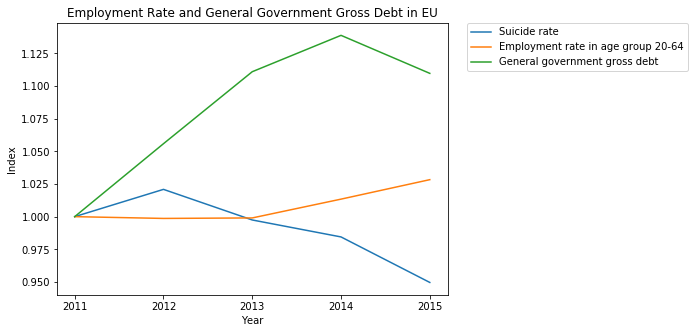

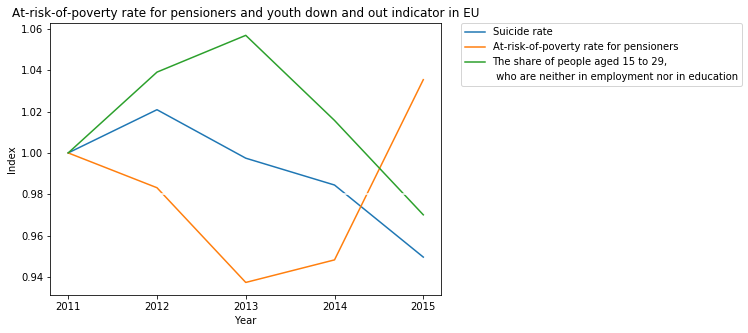

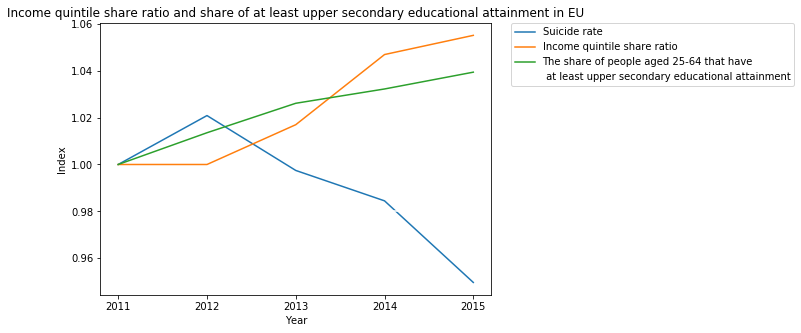

In [66]:
wholed2013 = eustat_df[eustat_df["year"]==eustat_df["year"][2]]
unp2013 = np.mean(wholed2013["employment"])
sui2013 = np.mean(wholed2013["suicides"])
los2013 = np.mean(wholed2013["lost children"])
edu2013 = np.mean(wholed2013["education"])
poo2013 = np.mean(wholed2013["poor retirees"])
deb2013 = np.mean(wholed2013["debt"])
eco2013 = np.mean(wholed2013["economy_equality"])


wholed2012 = eustat_df[eustat_df["year"]==eustat_df["year"][1]]
unp2012 = np.mean(wholed2012["employment"])
sui2012 = np.mean(wholed2012["suicides"])
los2012 = np.mean(wholed2012["lost children"])
edu2012 = np.mean(wholed2012["education"])
poo2012 = np.mean(wholed2012["poor retirees"])
deb2012 = np.mean(wholed2012["debt"])
eco2012 = np.mean(wholed2012["economy_equality"])


wholed2011 = eustat_df[eustat_df["year"]==eustat_df["year"][0]]
unp2011 = np.mean(wholed2011["employment"])
sui2011 = np.mean(wholed2011["suicides"])
los2011 = np.mean(wholed2011["lost children"])
edu2011 = np.mean(wholed2011["education"])
poo2011 = np.mean(wholed2011["poor retirees"])
deb2011 = np.mean(wholed2011["debt"])
eco2011 = np.mean(wholed2011["economy_equality"])


wholed2014 = eustat_df[eustat_df["year"]==eustat_df["year"][3]]
unp2014 = np.mean(wholed2014["employment"])
sui2014 = np.mean(wholed2014["suicides"])
los2014 = np.mean(wholed2014["lost children"])
edu2014 = np.mean(wholed2014["education"])
poo2014 = np.mean(wholed2014["poor retirees"])
deb2014 = np.mean(wholed2014["debt"])
eco2014 = np.mean(wholed2014["economy_equality"])


wholed2015 = eustat_df[eustat_df["year"]==eustat_df["year"][4]]
unp2015 = np.mean(wholed2015["employment"])
sui2015 = np.mean(wholed2015["suicides"])
los2015 = np.mean(wholed2015["lost children"])
edu2015 = np.mean(wholed2015["education"])
poo2015 = np.mean(wholed2015["poor retirees"])
deb2015 = np.mean(wholed2015["debt"])
eco2015 = np.mean(wholed2015["economy_equality"])

wholedmeans = np.array([sui2011, sui2012, sui2013, sui2014, sui2015])

wholedmeanu = np.array([unp2011, unp2012, unp2013, unp2014, unp2015])
wholedmeanl = np.array([los2011, los2012, los2013, los2014, los2015])
wholedmeane = np.array([edu2011, edu2012, edu2013, edu2014, edu2015])
wholedmeanp = np.array([poo2011, poo2012, poo2013, poo2014, poo2015])
wholedmeand = np.array([deb2011, deb2012, deb2013, deb2014, deb2015])
wholedmeaneq = np.array([eco2011, eco2012, eco2013, eco2014, eco2015])

wholedmeans = wholedmeans/wholedmeans[0]

wholedmeanu = wholedmeanu/wholedmeanu[0]
wholedmeanl = wholedmeanl/wholedmeanl[0]
wholedmeane  = wholedmeane/wholedmeane[0]
wholedmeanp = wholedmeanp/wholedmeanp[0]
wholedmeand  = wholedmeand/wholedmeand[0]
wholedmeaneq = wholedmeaneq/wholedmeaneq[0]
pipapo = np.array([0.98,0.98,0.98,0.98,0.98])

plt.rcParams['figure.figsize'] = [7, 5]


plt.plot(wholedmeans, label = "Suicide rate")
plt.plot(wholedmeanu, label = "Employment rate in age group 20-64")
plt.plot(wholedmeand, label = "General government gross debt")
plt.xlabel('Year')
plt.ylabel('Index')
plt.title('Employment Rate and General Government Gross Debt in EU')
plt.xticks(np.arange(5), ('2011', '2012', '2013', '2014', "2015"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
 
plt.plot(wholedmeans, label = "Suicide rate")
plt.plot(wholedmeanp, label = "At-risk-of-poverty rate for pensioners")
plt.plot(wholedmeanl, label = "The share of people aged 15 to 29,")
plt.plot(pipapo, label = " who are neither in employment nor in education",color='w')
plt.xlabel('Year')
plt.ylabel('Index')
plt.title('At-risk-of-poverty rate for pensioners and youth down and out indicator in EU')
plt.xticks(np.arange(5), ('2011', '2012', '2013', '2014', "2015"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(wholedmeans, label = "Suicide rate")
plt.plot(wholedmeaneq, label = "Income quintile share ratio")
plt.plot(wholedmeane, label = "The share of people aged 25-64 that have ")
plt.plot(pipapo, label = " at least upper secondary educational attainment",color='w')
plt.xlabel('Year')
plt.ylabel('Index')
plt.title('Income quintile share ratio and share of at least upper secondary educational attainment in EU')
plt.xticks(np.arange(5), ('2011', '2012', '2013', '2014', "2015"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [67]:
import geopandas as gp

# Geopandas

In [68]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
world = world.cx[-40:, :]

In [69]:
world = world[world["continent"]=="Europe"]
world = world.drop(columns = ['pop_est', 'continent', 'iso_a3', 'gdp_md_est'])
eustat_df2015 = eustat_df[eustat_df["year"]==eustat_df["year"][4]]
eustat_df2011 = eustat_df[eustat_df["year"]==eustat_df["year"][0]]
world.columns = ['country', 'geometry']
gp_eustat2015 = pd.merge(world, eustat_df2015, how = 'outer', on = ['country'])
gp_eustat2011 = pd.merge(world, eustat_df2011, how = 'outer', on = ['country'])

In [70]:
gp_eustat2015.at[14,'suicides'] = 7.35
gp_eustat2011.at[14,'suicides'] = 6.71
gp_eustat2015.at[7,'suicides'] = 13.24
gp_eustat2011.at[7,'suicides'] = 15.20
gp_eustat2015.at[29,'suicides'] = 11.71
gp_eustat2011.at[29,'suicides'] = 12.49
gp_eustat2015.at[19,'suicides'] = 13.06
gp_eustat2011.at[19,'suicides'] = 8.85

In [71]:
gp_eustat2011 = gp_eustat2011.fillna(0)
gp_eustat2011 = gp_eustat2011.drop(39)
gp_eustat2011 = gp_eustat2011.drop(40)
gp_eustat2011 = gp_eustat2011.drop(41)
gp_eustat2011 = gp_eustat2011.drop(33)
gp_eustat2011 = gp_eustat2011.drop(42)

In [72]:
gp_eustat2015 = gp_eustat2015.fillna(0)
gp_eustat2015 = gp_eustat2015.drop(39)
gp_eustat2015 = gp_eustat2015.drop(40)
gp_eustat2015 = gp_eustat2015.drop(41)
gp_eustat2015 = gp_eustat2015.drop(33)
gp_eustat2015 = gp_eustat2015.drop(42)

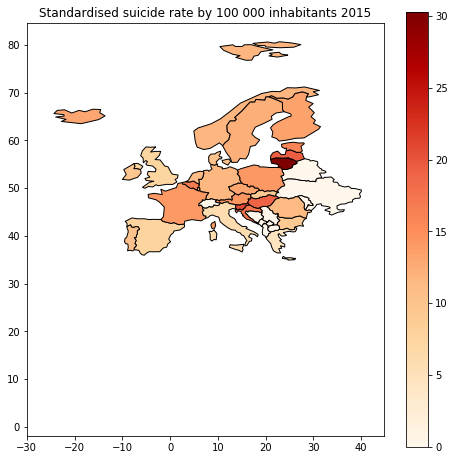

In [73]:
plt.rcParams['figure.figsize'] = [8, 8]
gp_eustat2015.plot(column='suicides', cmap='OrRd', edgecolor='black',legend=True)
plt.title("Standardised suicide rate by 100 000 inhabitants 2015")
plt.xlim(left=-30) 
plt.show()

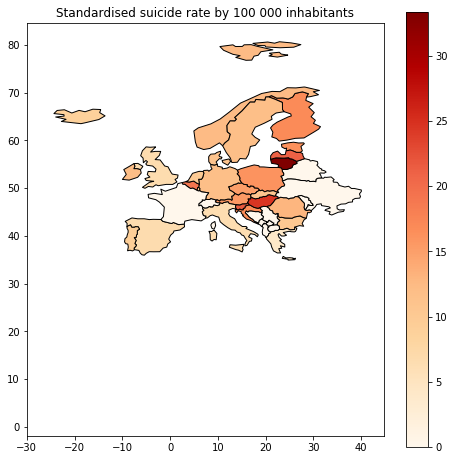

In [74]:
plt.rcParams['figure.figsize'] = [8, 8]
gp_eustat2011.plot(column='suicides', cmap='OrRd', edgecolor='black',legend=True)
plt.title("Standardised suicide rate by 100 000 inhabitants")
plt.xlim(left=-30) 
plt.show()

# Model

In [75]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import sklearn.linear_model as lm
import sklearn.preprocessing as sp
import numpy.random as npr
import statsmodels.api as sm
from sklearn.linear_model import Lasso

In [76]:
X = eustat_df.drop(["country"], axis = 1)
for key,value in X.loc[:, X.columns == 'year'].iteritems():
    for i, v in value.iteritems():
        X.at[i, key] = float(str(v).replace(' ', ''))
X.columns = ['year','poor retirees', 'employment', 'debt', 'lost children', 'economy_equality', 'education','suicides']  
Xl = sp.normalize(X)
Xl = pd.DataFrame(data=Xl)
Xl.columns = ['year','poor retirees', 'unemployment', 'debt', 'lost children', 'economy equality','education', 'suicides']
yl = Xl[["suicides"]]
Xl = Xl.drop(["suicides"], axis = 1)
Xl = Xl.drop(["year"], axis = 1)

In [77]:
X

,year,poor retirees,employment,debt,lost children,economy_equality,education,suicides
0,2011,15.5,74.2,82.4,8.5,4.1,82.4,15.54
1,2012,14.4,74.4,81.9,8.2,4.2,82.9,15.20
2,2013,14.6,74.6,81.3,8.6,4.1,83.0,15.35
3,2014,14.2,74.2,84.0,9.3,4.1,83.9,15.26
4,2015,12.9,74.3,84.6,8.7,4.0,84.6,14.48
5,2011,17.3,67.3,102.6,13.8,3.9,71.3,19.25
6,2012,16.7,67.2,104.3,14.4,4.0,71.6,18.76
7,2013,15.1,67.2,105.5,14.9,3.8,72.8,17.27
8,2014,12.9,67.3,107.0,14.1,3.8,73.6,17.28
9,2015,12.4,67.2,106.1,14.4,3.8,74.7,16.85


In [78]:
Xl = Xl.convert_objects(convert_numeric=True)
Xs = np.asarray(Xl)
model = sm.OLS(yl, Xs).fit()
predictions = model.predict(Xs)
model.summary()

C:\Users\Olga\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               suicides   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     183.0
Date:                Sat, 27 Oct 2018   Prob (F-statistic):           3.70e-61
Time:                        16:39:26   Log-Likelihood:                 634.45
No. Observations:                 137   AIC:                            -1257.
Df Residuals:                     131   BIC:                            -1239.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0237      0.068      0.349      0.728      -0.111       0.158
x2            -0.1758      0.056     -3.166      0.002      -0.286      -0.066
x3             0.0096      0.015      0.638      0.524      -0.020       0.040
x4            -0.4493      0.132     -3.394      0.001      -0.711      -0.187
x5             1.5570      0.546      2.853      0.005       0.478       2.636
x6             0.3015      0.040      7.601      0.000       0.223       0.380
==============================================================================
Omnibus:                       14.489   Durbin-Watson:                   0.442
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.715
Skew:                           0.766   Prob(JB):                     0.000387
Kurtosis:                       3.638   Cond. No.                         171.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
Xl.columns

Index(['poor retirees', 'unemployment', 'debt', 'lost children',
       'economy equality', 'education'],
      dtype='object')

Training score: 0.5042278605988209
Test score:  0.43932299637961536
Coefficients:  [[ 0.18468833 -0.91843204  0.01314349 -1.08048509  1.12823731  0.30174277]]


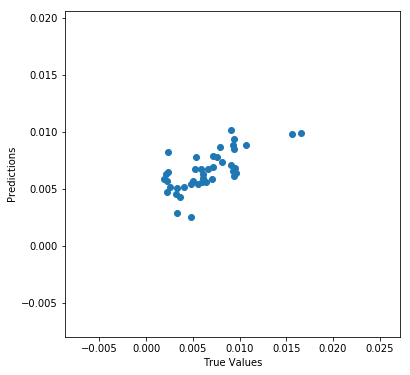

Training score: 0.4997371665070053
Test score:  0.4844671205873766
Coefficients:  [[ 0.12104818 -0.81758218 -0.00712112 -1.01114497  1.4823923   0.31078075]]


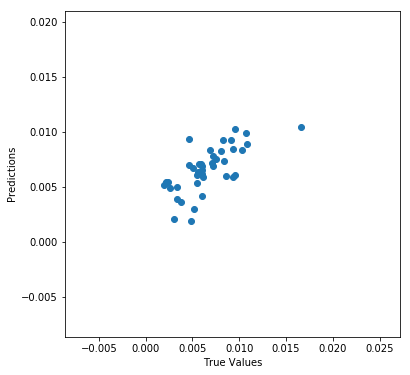

Training score: 0.4841707732578252
Test score:  0.47826348771881677
Coefficients:  [[ 0.12041971 -0.78002057 -0.00430527 -0.93732656  1.00890318  0.32207853]]


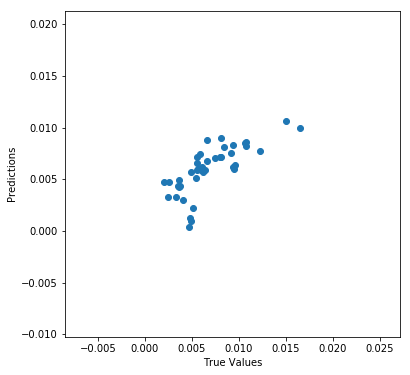

Training score: 0.49115687044227074
Test score:  0.4794811479289434
Coefficients:  [[ 0.11965322 -0.97394548  0.00222349 -1.1481867   1.1682549   0.34370628]]


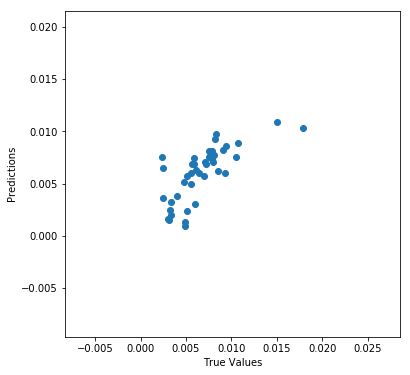

Training score: 0.4984260912681967
Test score:  0.41164577434166305
Coefficients:  [[ 2.31408864e-01 -8.19531710e-01 -3.80431839e-04 -1.05239585e+00
   1.05123881e+00  2.86540403e-01]]


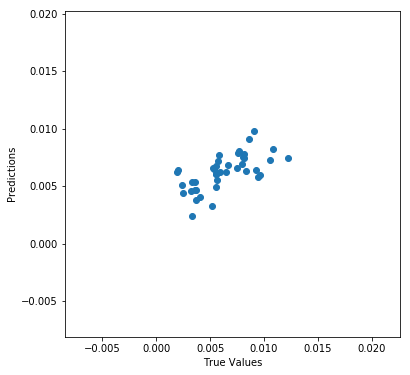

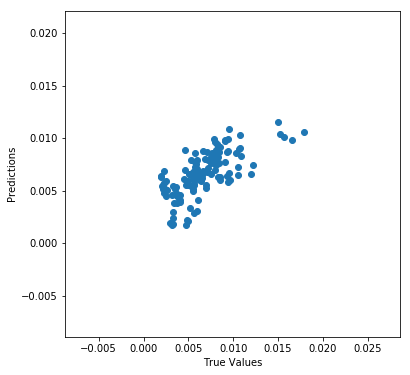

In [80]:
seeds = [1,3,7,9,11]
coefs= []
tests = []
plt.rcParams['figure.figsize'] = [6, 6]
trains = []

for i in range(0, len(seeds)):
    npr.seed(seeds[i])
    X_train, X_test, y_train, y_test = train_test_split(Xl, yl, test_size=0.30)
    lin = lm.LinearRegression()
    model = lin.fit(X_train, y_train)
    predictions = lin.predict(X_test)
    print("Training score:", model.score(X_train, y_train))
    tests.append(model.score(X_test, y_test))
    trains.append(model.score(X_train, y_train))
    print("Test score: ", model.score(X_test, y_test))
    print("Coefficients: ", model.coef_)
    cof = model.coef_[0]
    coefs.append(cof)
    plt.scatter(y_test, predictions)
    plt.plot()
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
predictions = lin.predict(Xl)    
plt.scatter(yl, predictions)
plt.plot()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()    

In [81]:
for i in range(0, len(Xl.columns)):
    print("variable:" , Xl.columns[i])
    print("coefficients:")
    for j in range(0, len(coefs)):
        s = coefs[j]
        print(s[i])
    print()    
    

variable: poor retirees
coefficients:
0.18468833255061828
0.12104818117499
0.12041970805224847
0.11965322246850446
0.2314088644040529

variable: unemployment
coefficients:
-0.9184320408465261
-0.8175821828652754
-0.7800205687098299
-0.9739454764683454
-0.8195317095626931

variable: debt
coefficients:
0.013143493929688313
-0.007121122549986361
-0.004305266595060638
0.0022234870251090985
-0.0003804318389164202

variable: lost children
coefficients:
-1.0804850919436852
-1.011144970539654
-0.9373265567789731
-1.1481867008439388
-1.0523958461518277

variable: economy equality
coefficients:
1.1282373054597485
1.4823923048838195
1.0089031803177133
1.168254902659169
1.0512388092737739

variable: education
coefficients:
0.3017427716564652
0.31078074789808013
0.3220785349845694
0.34370627982066415
0.28654040288985855



In [82]:
coeff = np.zeros(6)
for i in range(0, len(Xl.columns)):
    for j in range(0, len(coefs)):
        s = coefs[j]
        coeff[i] = coeff[i] + s[i]
coeff = coeff/5 
coeff[5] = coeff[5]*(-1)
print(coeff)    

[ 1.55443662e-01 -8.61902396e-01  7.12031994e-04 -1.04590783e+00
  1.16780530e+00 -3.12969747e-01]


In [83]:
print("Average test score: ", np.mean(tests))
print("Average training score: ", np.mean(trains))
print()
print("              Average coefficient:")
for i in range(0, len(coeff)):
    print(Xl.columns[i], "    " ,"%.4f" % coeff[i])

Average test score:  0.45863610539128297
Average training score:  0.49554375241482373

              Average coefficient:
poor retirees      0.1554
unemployment      -0.8619
debt      0.0007
lost children      -1.0459
economy equality      1.1678
education      -0.3130


Create a lasso model 

In [84]:
lasso = Lasso()

In [85]:
seeds = [1, 5, 21, 23]
alphas = np.array([0.00003,0.00001])

for j in range(0, len(alphas)):
    print("New alpha: ", alphas[j])
    print()
    for i in range(0, len(seeds)):
        npr.seed(seeds[i])
        X_train, X_test, y_train, y_test = train_test_split(Xl, yl, test_size=0.30)
        lasso = Lasso(alpha=alphas[j],normalize=True)
        lasso.fit(X_train,y_train)
        y_pred = lasso.predict(X_test)
        print("coefs:", lasso.coef_)
        print('test.score: ', lasso.score(X_test,y_test))
        print("number of coef: ", sum(lasso.coef_ != 0))
        print()

New alpha:  3e-05

coefs: [ 0.00429723 -0.         -0.         -0.          0.          0.17956515]
test.score:  0.285196897168177
number of coef:  2

coefs: [ 0.04966792 -0.         -0.         -0.          0.          0.21255219]
test.score:  0.21658529927000525
number of coef:  2

coefs: [ 0.         -0.04746962 -0.00533584 -0.02734931  0.          0.19754797]
test.score:  0.37710093726758576
number of coef:  4

coefs: [ 0.         -0.         -0.01246018 -0.0377021   0.          0.17322458]
test.score:  0.3015471989056193
number of coef:  3

New alpha:  1e-05

coefs: [ 0.12688718 -0.53463073 -0.         -0.59732498  0.39698871  0.2405255 ]
test.score:  0.41966437664844136
number of coef:  5

coefs: [ 0.13558748 -0.58450088  0.         -0.66898226  0.85614342  0.29168228]
test.score:  0.36324812900958703
number of coef:  5

coefs: [ 0.08811547 -0.67326959 -0.         -0.78496605  0.81497836  0.27182965]
test.score:  0.4556274071622741
number of coef:  5

coefs: [ 0.08737199 -0.52412

coefs: [ 0.13558748 -0.58450088  0.         -0.66898226  0.85614342  0.29168228]
test.score:  0.4645853210097536
number of coef:  5


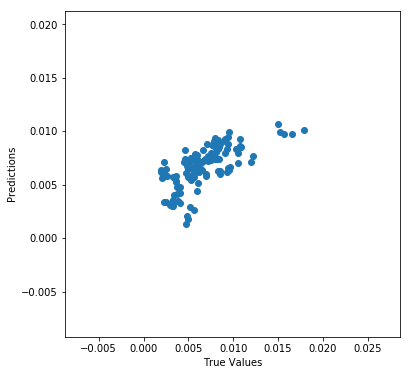

In [86]:
# model that we choose, alpha = 0.00001, no variable number three (debt)

npr.seed(5)
alpha = 0.00001
plt.rcParams['figure.figsize'] = [6, 6]
X_train, X_test, y_train, y_test = train_test_split(Xl, yl, test_size=0.30)
lasso = Lasso(alpha,normalize=True)
lasso.fit(X_train,y_train)
y_pred = lasso.predict(Xl)
print("coefs:", lasso.coef_)
print('test.score: ', lasso.score(Xl,yl))
print("number of coef: ", sum(lasso.coef_ != 0))
plt.scatter(yl, y_pred)
plt.plot()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

plot our coefficients to show their relationships to the suicide rate

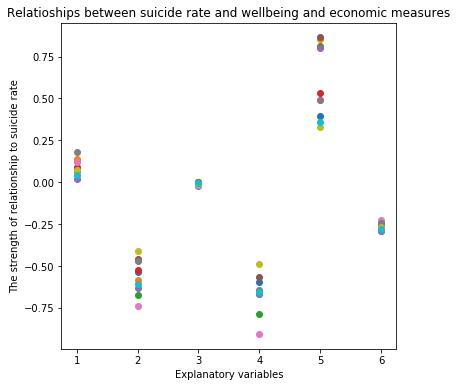

Average training score: 0.4749
Average test score: 0.3842


In [120]:
seeds = [1, 5, 21, 23, 2, 3, 6, 11, 7, 9]
trains = []
tests = []
coefs = []


for i in range(0, len(seeds)):
    npr.seed(seeds[i])
    X_train, X_test, y_train, y_test = train_test_split(Xl, yl, test_size=0.30)
    lasso = Lasso(alpha=0.00001,normalize=True)
    lasso.fit(X_train,y_train)
    trains.append(lasso.score(X_train,y_train))
    y_pred = lasso.predict(X_test)
    tests.append(lasso.score(X_test, y_test))
    coefs.append(lasso.coef_)

for i in range(0, len(seeds)):
    coefs[i][5] = coefs[i][5]*(-1)
plt.rcParams['figure.figsize'] = [6, 6]

for i in range(0, len(seeds)):
    plt.plot(coefs[i], 'o')
    plt.ylabel('The strength of relationship to suicide rate')
    plt.xlabel("Explanatory variables")
    plt.title('Relatioships between suicide rate and wellbeing and economic measures')
    plt.xticks(np.arange(6), ('1', '2', '3', '4', '5', '6'))
plt.show()    
print("Average training score: %.4f" % np.mean(trains))
print("Average test score: %.4f" % np.mean(tests))

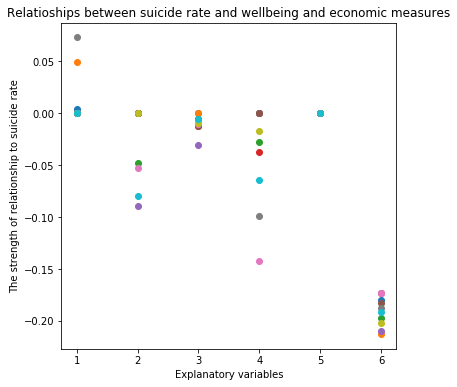

Average training score: 0.3436
Average test score: 0.2834


In [124]:
seeds = [1, 5, 21, 23, 2, 3, 6, 11, 7, 9]
tests = []
trainings = []
coefs = []


for i in range(0, len(seeds)):
    npr.seed(seeds[i])
    X_train, X_test, y_train, y_test = train_test_split(Xl, yl, test_size=0.30)
    lasso = Lasso(alpha=0.00003,normalize=True)
    lasso.fit(X_train,y_train)
    tests.append(lasso.score(X_test, y_test))
    trains.append(lasso.score(X_train,y_train))
    y_pred = lasso.predict(X_test)
    coefs.append(lasso.coef_)

for i in range(0, len(seeds)):
    coefs[i][5] = coefs[i][5]*(-1)
    
plt.rcParams['figure.figsize'] = [6, 6]
for i in range(0, len(seeds)):
    plt.plot(coefs[i], 'o')
    plt.ylabel('The strength of relationship to suicide rate')
    plt.xlabel("Explanatory variables")
    plt.title('Relatioships between suicide rate and wellbeing and economic measures')
    plt.xticks(np.arange(6), ('1', '2', '3', '4', '5', '6'))
plt.show()      
print("Average training score: %.4f" % np.mean(trains))
print("Average test score: %.4f" % np.mean(tests))

In [108]:
# denormalize data, m = max, n = min, 3.35 = error term
npr.seed(5)
alpha = 0.00001
plt.rcParams['figure.figsize'] = [6, 6]
X_train, X_test, y_train, y_test = train_test_split(Xl, yl, test_size=0.30)
lasso = Lasso(alpha,normalize=True)
lasso.fit(X_train,y_train)
y_pred = lasso.predict(Xl)
m = 2015
n = 3.4
ny_pred = n+y_pred*(m-n)-3.35

In [109]:
ny_pred = pd.DataFrame(data=ny_pred)
result = pd.concat([X, ny_pred, eustat_df["country"]], axis=1, sort=False)

,year,poor retirees,employment,debt,lost children,economy_equality,education,suicides,0,country
0,2011,15.5,74.2,82.4,8.5,4.1,82.4,15.54,15.472181,Austria
1,2012,14.4,74.4,81.9,8.2,4.2,82.9,15.20,15.647389,Austria
2,2013,14.6,74.6,81.3,8.6,4.1,83.0,15.35,15.244257,Austria
3,2014,14.2,74.2,84.0,9.3,4.1,83.9,15.26,15.229115,Austria
4,2015,12.9,74.3,84.6,8.7,4.0,84.6,14.48,15.523241,Austria
5,2011,17.3,67.3,102.6,13.8,3.9,71.3,19.25,12.804158,Belgium
6,2012,16.7,67.2,104.3,14.4,4.0,71.6,18.76,12.565565,Belgium
7,2013,15.1,67.2,105.5,14.9,3.8,72.8,17.27,12.206096,Belgium
8,2014,12.9,67.3,107.0,14.1,3.8,73.6,17.28,12.628470,Belgium
9,2015,12.4,67.2,106.1,14.4,3.8,74.7,16.85,12.749595,Belgium


In [110]:
result.columns = ['year','poor retirees', 'employment', 'debt', 'lost children', 'economy_equality', 'education','suicides', 'pred_sui', 'Country'] 


Create a geopanda plot using our model

In [111]:
import geopandas as gp
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
world = world.cx[-40:, :]

In [112]:
world = world[world["continent"]=="Europe"]
world = world.drop(columns = ['pop_est', 'continent', 'iso_a3', 'gdp_md_est'])
result2015 = result[result["year"]==result["year"][4]]
world.columns = ['Country', 'geometry']
result2015 = pd.merge(world, result2015, how = 'outer', on = ['Country'])

,Country,geometry,year,poor retirees,employment,debt,lost children,economy_equality,education,suicides,pred_sui
0,Albania,"POLYGON ((20.59024743010491 41.85540416113361,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Austria,"POLYGON ((16.97966678230404 48.12349701597631,...",2015,12.9,74.3,84.6,8.7,4.0,84.6,14.48,15.523241
2,Belgium,"POLYGON ((3.314971144228537 51.34578095153609,...",2015,12.4,67.2,106.1,14.4,3.8,74.7,16.85,12.749595
3,Bulgaria,"POLYGON ((22.65714969248299 44.23492300066128,...",2015,30.0,67.1,26.0,22.2,7.1,81.9,9.33,14.871240
4,Bosnia and Herz.,"POLYGON ((19.00548628101012 44.86023366960916,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Belarus,"POLYGON ((23.48412763844985 53.91249766704114,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Switzerland,"POLYGON ((9.59422610844635 47.52505809182027, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Czech Rep.,"POLYGON ((16.96028812019458 48.5969823268506, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Germany,"POLYGON ((9.921906365609232 54.98310415304803,...",2015,17.0,78.0,71.0,8.5,4.8,86.8,11.67,15.374841
9,Denmark,(POLYGON ((12.69000613775563 55.60999095318078...,2015,8.8,76.5,39.9,7.7,4.1,80.4,10.21,13.204338


In [113]:
result2015 = result2015.fillna(0)
result2015 = result2015.drop(39)
result2015 = result2015.drop(40)
result2015 = result2015.drop(41)
result2015 = result2015.drop(33)
result2015 = result2015.drop(42)

In [114]:
result2015.at[14,'pred_sui'] = 11.733113
result2015.at[7,'pred_sui'] = 14.486038
result2015.at[27,'pred_sui'] = 30.4

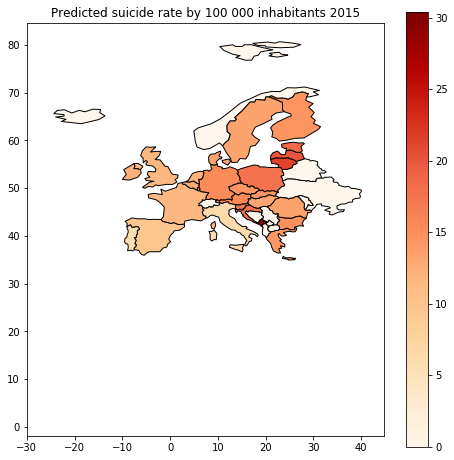

In [115]:
plt.rcParams['figure.figsize'] = [8, 8]
result2015.plot(column='pred_sui', cmap='OrRd', edgecolor='black',legend=True)
plt.title("Predicted suicide rate by 100 000 inhabitants 2015")
plt.xlim(left=-30) 
plt.show()

# Geopandas and economic and wellbeing measures

In [97]:
# some values had disappeared? Have to add them.
result2015.at[7,'employment'] = 74.8
result2015.at[14,'employment'] = 76.8
result2015.at[19,'employment'] = 86.5
result2015.at[6,'employment'] = 81.7
result2015.at[29,'employment'] = 79.1

result2015.at[7,'poor retirees'] = 7.4
result2015.at[14,'poor retirees'] = 18.3
result2015.at[19,'poor retirees'] = 7.3
result2015.at[6,'poor retirees'] = 27.6
result2015.at[29,'poor retirees'] = 10.1

result2015.at[7,'debt'] = 40
result2015.at[14,'debt'] = 87.9

result2015.at[7,'lost children'] = 11.8
result2015.at[14,'lost children'] = 12.7
result2015.at[19,'lost children'] = 5.3
result2015.at[6,'lost children'] = 7.3
result2015.at[29,'lost children'] = 7

result2015.at[7,'education'] = 93.2
result2015.at[14,'education'] = 79.7
result2015.at[19,'education'] = 75
result2015.at[6,'education'] = 87.3
result2015.at[29,'education'] = 82.7

result2015.at[7,'economy_equality'] = 3.5
result2015.at[14,'economy_equality'] = 5.2
result2015.at[19,'economy_equality'] = 3.4
result2015.at[6,'economy_equality'] = 4.5
result2015.at[29,'economy_equality'] = 3.5

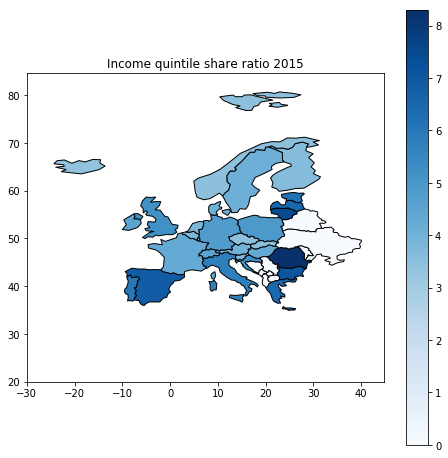

In [98]:
plt.rcParams['figure.figsize'] = [8, 8]
result2015.plot(column='economy_equality', cmap='Blues', edgecolor='black',legend=True)
plt.title("Income quintile share ratio 2015")
plt.xlim(left=-30) 
plt.ylim(bottom=20)
plt.show()

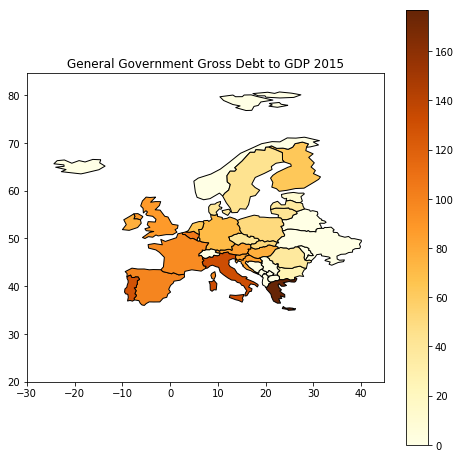

In [99]:
result2015.plot(column='debt', cmap='YlOrBr', edgecolor='black',legend=True)
plt.title("General Government Gross Debt to GDP 2015")
plt.xlim(left=-30) 
plt.ylim(bottom=20)
plt.show()

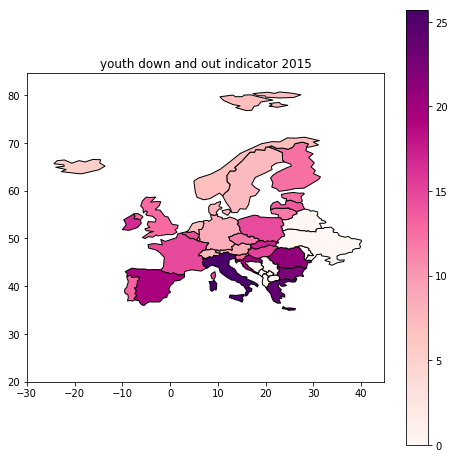

In [100]:
result2015.plot(column='lost children', cmap='RdPu', edgecolor='black',legend=True)
plt.title("youth down and out indicator 2015")
plt.xlim(left=-30) 
plt.ylim(bottom=20)
plt.show()

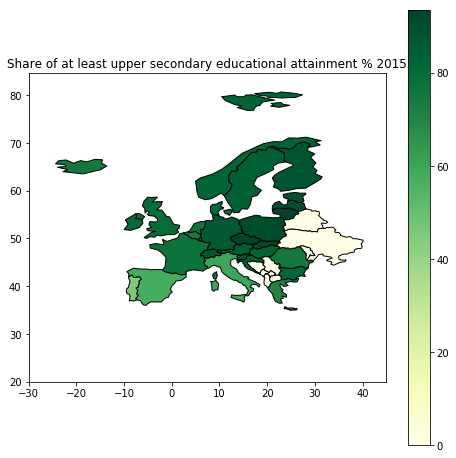

In [101]:
result2015.plot(column='education', cmap='YlGn', edgecolor='black',legend=True)
plt.title("Share of at least upper secondary educational attainment % 2015")
plt.xlim(left=-30) 
plt.ylim(bottom=20)
plt.show()

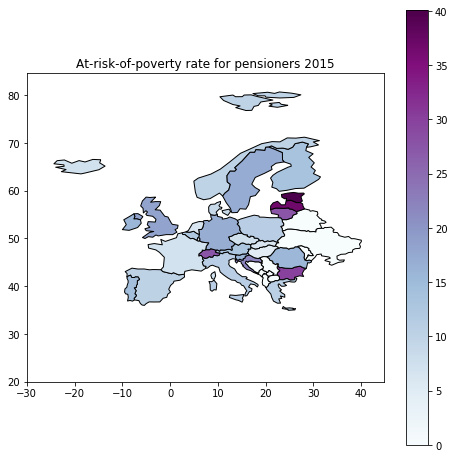

In [102]:
result2015.plot(column='poor retirees', cmap='BuPu', edgecolor='black',legend=True)
plt.title("At-risk-of-poverty rate for pensioners 2015")
plt.xlim(left=-30) 
plt.ylim(bottom=20)
plt.show()

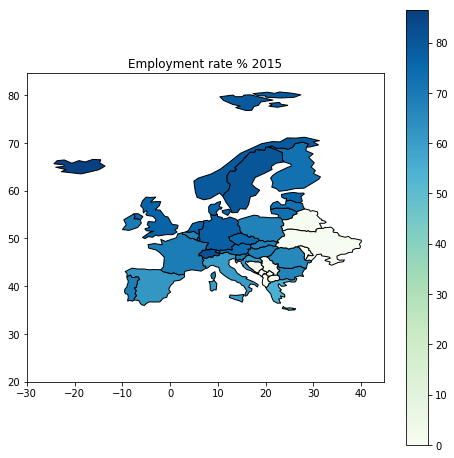

In [103]:
result2015.plot(column='employment', cmap='GnBu', edgecolor='black',legend=True)
plt.title("Employment rate % 2015")
plt.xlim(left=-30) 
plt.ylim(bottom=20)
plt.show()